In [1]:
!nvidia-smi


Wed Dec 10 05:19:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Step 1: Install Dependencies

In [ ]:
# Install COLMAP
!sudo apt-get update
!sudo apt-get install -y colmap

# Install git & cmake & required libraries for Instant-NGP
!sudo apt-get install -y git cmake build-essential libglfw3-dev libglew-dev libomp-dev libxinerama-dev libxcursor-dev libxi-dev

# Clone Instant-NGP (with --recursive flag for submodules)
!rm -rf instant-ngp # Remove the old, incomplete clone
!git clone --recursive https://github.com/NVlabs/instant-ngp
%cd instant-ngp
!cmake . -B build
!cmake --build build --config RelWithDebInfo -j 16

# Go back to root
%cd /content

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [4]:
import zipfile
import os

# Path to your uploaded zip file
zip_path = "/content/fern_images.zip"  # Adjust if the name is different

# Directory to extract images
extract_dir = "/content/fern_images"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List all extracted files
image_files = os.listdir(extract_dir)
print("Images in the folder:", image_files)


Images in the folder: ['fern_images']


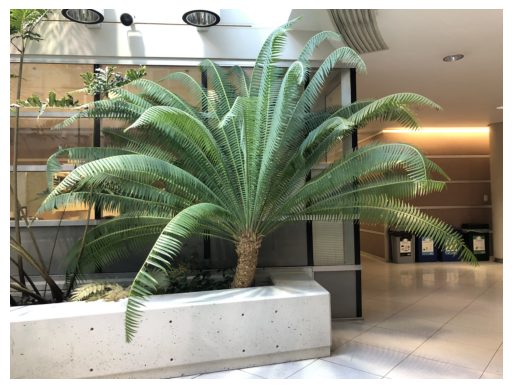

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

# Correct the path to the actual directory containing images
actual_image_dir = os.path.join(extract_dir, image_files[0])
# List the files within the actual image directory
actual_image_files = os.listdir(actual_image_dir)

# Filter for actual image files if necessary, or assume the first one is an image
# For simplicity, we'll assume the first entry in the new list is an image
img_path = os.path.join(actual_image_dir, actual_image_files[0])

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
import os

images_folder = "/content/fern_images/fern_images"
colmap_output = "/content/colmap_output"

os.makedirs(colmap_output, exist_ok=True)


In [12]:
import subprocess
import os

def run_command(cmd):
    print("Running:", " ".join(cmd))
    # Capture stdout and stderr for better debugging
    process = subprocess.run(cmd, capture_output=True, text=True, check=False)
    print("STDOUT:", process.stdout)
    print("STDERR:", process.stderr)
    process.check_returncode() # Raise CalledProcessError if return code is non-zero

database_path = os.path.join(colmap_output, "database.db")
sparse_path = os.path.join(colmap_output, "sparse")

os.makedirs(sparse_path, exist_ok=True)

# Set QT_QPA_PLATFORM to offscreen to prevent display errors in headless environments
os.environ["QT_QPA_PLATFORM"] = "offscreen"

# 1  Feature Extraction
# Explicitly set use_gpu to 0 to avoid potential GPU-related crashes
run_command([
    "colmap", "feature_extractor",
    "--database_path", database_path,
    "--image_path", images_folder,
    "--SiftExtraction.use_gpu", "0" # Use CPU for SIFT extraction
])

# 2  Feature Matching
run_command([
    "colmap", "exhaustive_matcher",
    "--database_path", database_path,
    "--SiftMatching.use_gpu", "0" # Use CPU for SIFT matching as well
])

# 3  Sparse Reconstruction
run_command([
    "colmap", "mapper",
    "--database_path", database_path,
    "--image_path", images_folder,
    "--output_path", sparse_path
])

# 4  Convert to TXT for Instant-NGP
sparse_text_path = os.path.join(colmap_output, "sparse_text")
os.makedirs(sparse_text_path, exist_ok=True)

run_command([
    "colmap", "model_converter",
    "--input_path", os.path.join(sparse_path, "0"),
    "--output_path", sparse_text_path,
    "--output_type", "TXT"
])

print("COLMAP processing completed!")


Running: colmap feature_extractor --database_path /content/colmap_output/database.db --image_path /content/fern_images/fern_images --SiftExtraction.use_gpu 0
STDOUT: WARNING: Your current options use the maximum number of threads on the machine to extract features. Exracting SIFT features on the CPU can consume a lot of RAM per thread for large images. Consider reducing the maximum image size and/or the first octave or manually limit the number of extraction threads. Ignore this warning, if your machine has sufficient memory for the current settings.

Feature extraction

Processed file [1/20]
  Name:            image000.png
  SKIP: Features for image already extracted.
Processed file [2/20]
  Name:            image001.png
  SKIP: Features for image already extracted.
Processed file [3/20]
  Name:            image002.png
  SKIP: Features for image already extracted.
Processed file [4/20]
  Name:            image003.png
  SKIP: Features for image already extracted.
Processed file [5/20]


In [13]:
instant_ngp_path = "/content/instant-ngp/build/testbed"
ngp_output = "/content/instant_ngp_output"
os.makedirs(ngp_output, exist_ok=True)

# Create config.json for Instant-NGP
config_json = os.path.join(ngp_output, "config.json")

config_data = f'''
{{
    "mode": "nerf",
    "scene": "{images_folder}",
    "load_colmap": "{sparse_text_path}",
    "nerf": {{
        "aabb_scale": 1
    }}
}}
'''

with open(config_json, "w") as f:
    f.write(config_data)

print("Config file created:", config_json)

# Run Instant-NGP training
run_command([
    instant_ngp_path,
    "--scene", config_json,
    "--save_snapshot", os.path.join(ngp_output, "trained_model.msgpack"),
    "--train", "True"
])


Config file created: /content/instant_ngp_output/config.json
Running: /content/instant-ngp/build/testbed --scene /content/instant_ngp_output/config.json --save_snapshot /content/instant_ngp_output/trained_model.msgpack --train True


FileNotFoundError: [Errno 2] No such file or directory: '/content/instant-ngp/build/testbed'